In [17]:
%matplotlib inline
import scipy.sparse as sparse
import scipy.sparse.linalg as linalg
import matplotlib.pyplot as plt
import numpy as np
import sys
from mpl_toolkits.mplot3d import Axes3D
from IPython.display import Image
from IPython.display import HTML

In [18]:
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

# Quantum dynamics

For this assignment we want to calculate the solution to the time-dependent Schrödinger equation so that we can evolve wave packets in time. We have done this using the Crank-Nicolson method for 1D and 2D, where we have simulated a gaussian wavepacket incident on a rectangular and triangular potential barrier (1D) as well as a gaussian wavefront incident on a double slit (2D). In this notebook we will first describe how we have found a solution to the SE using the Crank-Nicolson method for both 1D and 2D, followed by the plots and/or animations corresponding to our simulations on the potential barriers as described above.

## Crank-Nicolson method on the time-dependent Schrödinger equation

To solve the time-dependent Schrödinger equation, we use the Crank-Nicolson method. With the help of this method, we find the following equation:
$$i\hbar \frac{{\psi \left( {x,t + \Delta t} \right) - \psi \left( {x,t} \right)}}{{\Delta t}} = \frac{1}{2}\hat H\left( {t + \Delta t} \right)\psi \left( {x,t + \Delta t} \right) + \frac{1}{2}\hat H\left( t \right)\psi \left( {x,t} \right)\\
\left( {1 + \frac{{i\Delta t}}{{2\hbar }}\hat H\left( {t + \Delta t} \right)} \right)\psi \left( {x,t + \Delta t} \right) = \left( {1 - \frac{{i\Delta t}}{{2\hbar }}\hat H\left( t \right)} \right)\psi \left( {x,t} \right)$$
Now we need the discretised Hamiltonian
$$\hat H\left( t \right)\psi \left( {x,t} \right) =  - \frac{{{\hbar ^2}}}{{2m}}\frac{{{\partial ^2}\psi \left( {x,t} \right)}}{{\partial {x^2}}} + V\left( {x,t} \right)\psi \left( {x,t} \right)\\
\hat H\left( t \right)\psi \left( {x,t} \right) =  - \frac{{{\hbar ^2}}}{{2m}}\left( {\frac{{\psi \left( {x + \Delta x,t} \right) - 2\psi \left( {x,t} \right) + \psi \left( {x - \Delta x,t} \right)}}{{\Delta {x^2}}}} \right) + V\left( {x,t} \right)\psi \left( {x,t} \right)$$
Filling this into the Crank-Nicholson equation gives us the following equation
$$\left( {1 + \frac{{i\Delta t}}{{2\hbar }}\hat H\left( {t + \Delta t} \right)} \right)\psi \left( {x,t + \Delta t} \right) = \left( {1 - \frac{{i\Delta t}}{{2\hbar }}\hat H\left( t \right)} \right)\psi \left( {x,t} \right)\\
 - {c_1}\psi \left( {x + \Delta x,t + \Delta t} \right) + \left( {1 + 2{c_1} + {c_2}} \right)\psi \left( {x,t + \Delta t} \right) - {c_1}\psi \left( {x - \Delta x,t + \Delta t} \right) = \\
{c_1}\psi \left( {x + \Delta x,t} \right) + \left( {1 - 2{c_1} - {c_2}} \right)\psi \left( {x,t} \right) + {c_1}\psi \left( {x - \Delta x,t} \right)$$
with coefficients
$${c_1} = \frac{{i\hbar \Delta t}}{{4m\Delta {x^2}}}\,\,\,\,,\,\,\,\,{c_2} = \frac{{iV\left( {x,t} \right)\Delta t}}{{2\hbar }}$$
Now we have a set of implicit equations that we need to solve to update the wave function. We rewrite these equations in terms of (tri-diagonal) matrices and vectors to ease the computation:
$$A\,\vec \psi \left( {t + \Delta t} \right) = B\,\vec \psi \left( t \right)$$

$$A = \left[ {\begin{array}{*{20}{c}}
{1 + 2{c_1} + {c_2}}&{ - {c_1}}&0&{}\\
{ - {c_1}}&{1 + 2{c_1} + {c_2}}&{ - {c_1}}&{}\\
0&{ - {c_1}}&{1 + 2{c_1} + {c_2}}&{}\\
0&0&{ - {c_1}}& \ddots 
\end{array}} \right]$$

$$B = \left[ {\begin{array}{*{20}{c}}
{1 - 2{c_1} - {c_2}}&{{c_1}}&0&{}\\
{{c_1}}&{1 - 2{c_1} - {c_2}}&{{c_1}}&{}\\
0&{{c_1}}&{1 - 2{c_1} - {c_2}}&{}\\
0&0&{{c_1}}& \ddots 
\end{array}} \right]$$

$$\vec \psi \left( t \right) = \left[ {\begin{array}{*{20}{c}}
{\psi \left( {{x_0},t} \right)}\\
{\psi \left( {{x_0} + \Delta x,t} \right)}\\
{\psi \left( {{x_0} + 2\Delta x,t} \right)}\\
 \vdots 
\end{array}} \right]$$

We can now update the wave function by solving this system of equations. We choose a stabilized bi-conjugate gradient method for this (the function linalg.bicgstab in Python).

To generalize the above method to 2D, the method is almost identical. The only difference is that we need a 2D Hamiltonian for this system:

$$
\hat H\left( t \right)\psi \left( {x,t} \right) =  - \frac{{{\hbar ^2}}}{{2m}}\left( {\frac{{{\partial ^2}\psi \left( {x,y,t} \right)}}{{\partial {x^2}}} + \frac{{{\partial ^2}\psi \left( {x,y,t} \right)}}{{\partial {y^2}}}} \right) + V\left( {x,y,t} \right)\psi \left( {x,y,t} \right)\\
\hat H\left( t \right)\psi \left( {x,t} \right) =  - \frac{{{\hbar ^2}}}{{2m}}\left( {\frac{{\psi \left( {x + \Delta x,y,t} \right) - 2\psi \left( {x,y,t} \right) + \psi \left( {x - \Delta x,y,t} \right)}}{{\Delta {x^2}}}} \right. + \\
\left. {\frac{{\psi \left( {x,y + \Delta y,t} \right) - 2\psi \left( {x,y,t} \right) + \psi \left( {x,y - \Delta y,t} \right)}}{{\Delta {y^2}}}} \right) + V\left( {x,y,t} \right)\psi \left( {x,y,t} \right)
$$

On a square grid this gives the following equation

$$
\hat H\left( t \right)\psi \left( {x,y,t} \right) =  - \frac{{{\hbar ^2}}}{{2m}}\left. {\left( {\frac{{\psi \left( {x + \Delta x,y,t} \right) + \psi \left( {x,y + \Delta y,t} \right) - 4\psi \left( {x,y,t} \right) + \psi \left( {x - \Delta x,y,t} \right) + \psi \left( {x,y - \Delta y,t} \right)}}{{{a^2}}}} \right.} \right) + V\left( {x,y,t} \right)\psi \left( {x,y,t} \right) - {c_1}\psi \left( {x + \Delta x,y,t + \Delta t} \right) - {c_1}\psi \left( {x,y + \Delta y,t + \Delta t} \right) + \left( {1 + 4{c_1} + {c_2}} \right)\psi \left( {x,y,t + \Delta t} \right) - {c_1}\psi \left( {x - \Delta x,y,t + \Delta t} \right) - {c_1}\psi \left( {x - \Delta x,y - \Delta y,t + \Delta t} \right)\\
 = {c_1}\psi \left( {x + \Delta x,y,t} \right) + {c_1}\psi \left( {x,y + \Delta y,t} \right) + \left( {1 - 4{c_1} - {c_2}} \right)\psi \left( {x,y,t} \right) + {c_1}\psi \left( {x - \Delta x,y,t} \right) + {c_1}\psi \left( {x - \Delta x,y - \Delta y,t} \right)
$$

This can now also be written in terms of matrices and vectors. The resulting matrix is tri-diagonal with two additional bands left and right of the main diagonal, at a distance of $\sqrt{N}$, with $N$ the total number of gridpoints.

$$
A\,\vec \psi \left( {t + \Delta t} \right) = B\,\vec \psi \left( t \right)\\
A = \left[ {\begin{array}{*{20}{c}}
 \ddots \\
 \ddots \\
 \ddots \\
 \ddots 
\end{array}\,\,\begin{array}{*{20}{c}}
{ - {c_1}}&0&0&0\\
0&{ - {c_1}}&0&0\\
0&0&{ - {c_1}}&0\\
0&0&0&{ - {c_1}}
\end{array}\,\,\,\,\begin{array}{*{20}{c}}
 \cdots \\
 \cdots \\
 \cdots \\
 \cdots 
\end{array}\,\,\,\begin{array}{*{20}{c}}
{1 + 4{c_1} + {c_2}}&{ - {c_1}}&0& \cdots \\
{ - {c_1}}&{1 + 4{c_1} + {c_2}}&{ - {c_1}}& \cdots \\
0&{ - {c_1}}&{1 + 4{c_1} + {c_2}}& \cdots \\
0&0&{ - {c_1}}& \cdots 
\end{array}\,\,\,\begin{array}{*{20}{c}}
{ - {c_1}}&0&0&0\\
0&{ - {c_1}}&0&0\\
0&0&{ - {c_1}}&0\\
0&0&0&{ - {c_1}}
\end{array}\,\,\begin{array}{*{20}{c}}
 \ddots \\
 \ddots \\
 \ddots \\
 \ddots 
\end{array}\,} \right]\\
B = \left[ {\begin{array}{*{20}{c}}
 \ddots \\
 \ddots \\
 \ddots \\
 \ddots 
\end{array}\,\,\begin{array}{*{20}{c}}
{{c_1}}&0&0&0\\
0&{{c_1}}&0&0\\
0&0&{{c_1}}&0\\
0&0&0&{{c_1}}
\end{array}\,\,\,\,\begin{array}{*{20}{c}}
 \cdots \\
 \cdots \\
 \cdots \\
 \cdots 
\end{array}\,\,\,\begin{array}{*{20}{c}}
{1 - 4{c_1} - {c_2}}&{{c_1}}&0& \cdots \\
{{c_1}}&{1 - 4{c_1} - {c_2}}&{{c_1}}& \cdots \\
0&{{c_1}}&{1 - 4{c_1} - {c_2}}& \cdots \\
0&0&{{c_1}}& \cdots 
\end{array}\,\,\,\begin{array}{*{20}{c}}
{{c_1}}&0&0&0\\
0&{{c_1}}&0&0\\
0&0&{{c_1}}&0\\
0&0&0&{{c_1}}
\end{array}\,\,\begin{array}{*{20}{c}}
 \ddots \\
 \ddots \\
 \ddots \\
 \ddots 
\end{array}\,} \right]\\
\vec \psi \left( t \right) = \left[ {\begin{array}{*{20}{c}}
{\psi \left( {{x_0},{y_0},t} \right)}\\
{\psi \left( {{x_0} + a,{y_0},t} \right)}\\
{\psi \left( {{x_0} + 2a,{y_0},t} \right)}\\
{\begin{array}{*{20}{c}}
 \vdots \\
{\psi \left( {{x_0},{y_0} + a,t} \right)}\\
{\psi \left( {{x_0} + a,{y_0} + a,t} \right)}\\
 \vdots 
\end{array}}
\end{array}} \right]
$$

## 1D Wavepacket through rectangular barrier


An example of how the code will run with only 10 points on the graph. The bigger plots below are for 301 points.

---- epsilon=0.8 (1/10) ----
---- epsilon=1.044 (2/10) ----
---- epsilon=1.289 (3/10) ----
---- epsilon=1.533 (4/10) ----
---- epsilon=1.778 (5/10) ----
---- epsilon=2.022 (6/10) ----
---- epsilon=2.267 (7/10) ----
---- epsilon=2.511 (8/10) ----
---- epsilon=2.756 (9/10) ----
---- epsilon=3.0 (10/10) ----


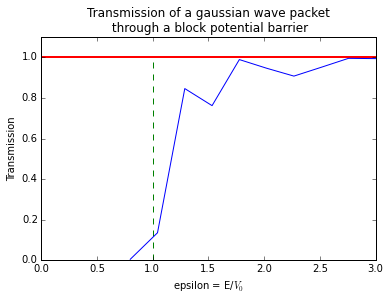

In [19]:
import scipy.sparse as sparse
import scipy.sparse.linalg as linalg
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.animation as animation
import sys
from time import gmtime, strftime


# Crank-Nicolson method QD time evolution simulation of a gaussian
# wave packet incident on a rectangular potential barrier
def main():

    ## simulation constants ##

    # epsilon is E/v0
    epsilon = np.linspace(0.8, 3.0, 10)

    v0 = 6.125  # barrier height,
    a = 2.      # barrier width
    sigma = 22. # gaussian wave packet spread
    dt = .1     # time step
    dx = .1     # spatial grid distance
    L = 300.    # simulation space length

    animate_and_print = False   # animate the time evolution
    plotTransmission = True     # plot the transmission
    saveTransmission = False     # save the transmission
    shape = "block"              # pick from 'triangle' and 'blok'

    T = np.zeros(len(epsilon))
    x = np.linspace(0, L, np.floor(L/dx))
    v = potential(x, v0, a, L, shape)

    # loop over epsilon
    for i,k in enumerate(np.sqrt(2*epsilon*v0)):

        print "---- epsilon={eps} ({i}/{n}) ----".format(eps=round(epsilon[i],3),i=i+1,n=len(epsilon))
        psi = init_psi(x, (L-a)/2 - 3*sigma, sigma, k, dx)
        A, B = calculate_AB(dx, dt, v)

        if animate_and_print:
            fig, ax ,ims = init_animation(psi, x, v, v0)
            psi, T[i] = run(A, B, x, psi, a, L, dx, ims)
            print_norms(psi, a, L, dx)
            im_ani = animation.ArtistAnimation(fig, ims, interval=10, repeat_delay=500, blit=True)
            plt.show()
        else:
            psi, T[i] = run(A, B, x, psi, a, L, dx)

    if plotTransmission: plot_transmission(epsilon, T, shape, saveTransmission)


###############
## functions ##
###############

# calculate the matrices for the Crank-Nicolson method
# A = Identity + constant*Hamiltonian
# B = Identity - constant*Hamiltonian
def calculate_AB(dx, dt, v):
    n = len(v)

    # two constants to simplify the expressions
    c1 = 1.j * dt / (4. * dx**2)
    c2 = 1.j * dt / 2.

    A = sparse.diags(1.+2.*c1+c2*v, 0) - c1*sparse.eye(n,n,1) - c1*sparse.eye(n,n,-1)
    B = sparse.diags(1.-2.*c1-c2*v, 0) + c1*sparse.eye(n,n,1) + c1*sparse.eye(n,n,-1)

    # fill in for periodic boundary conditions
    A = A + sparse.diags([[-c1, 0],[0, -c1]],[n-2, 2-n])
    B = B + sparse.diags([[c1, 0],[0, c1]],[n-2, 2-n])

    return A, B

# run the time evolution and return the transmission by solving the
# matrix equation A*psi(t+dt) = B*psi(t) using the bicgstab method.
# The function stops time stepping and calculates the transmission
# when the norm in the barrier has reduced below 10e-6
def run(A, B, x, psi, a, L, dx, ims = None):

    y = 2*np.max(abs(psi))**2
    c = cn = i = 0
    while cn>=c or c>10e-6:
        c = cn
        if ims!=None and i%4==0:
            plt.axis((0,L,0,y))
            im, = plt.plot(x, np.abs(psi)**2, 'b')
            ims.append([im])

        # use the sparse stabilized biconjugate gradient method to solve the matrix eq
        [psi, error] = linalg.bicgstab(A, B*psi, x0=psi)
        if error != 0: sys.exit("bicgstab did not converge")

        i = i+1
        # calculate the new norm in the barrier
        cn = sum(abs(psi[int(round((L - a)/(2*dx))):int(round((L + a)/(2*dx)))])**2)*dx

    return psi, sum(abs(psi[int(round((L - a)/(2*dx))):])**2)*dx/(sum(abs(psi)**2)*dx)

# initialize the wave function
def init_psi(x, x0, sigma, k, dx):
    # create a gaussian wave function moving in the positive x direction
    psi = np.exp(-(1/(2*sigma**2))*(x-x0)**2) * np.exp(1.j*k*x)
    # normalize the wave function
    psi /= np.sqrt(sum(abs(psi)**2*dx))

    return psi

# initialize a rectangular potential barrier at position s
def potential(x, v0, a, L, shape):
    if shape.lower() == 'triangle':
        v = (v0/a)*(x+(a-L)/2)*(abs(x-L/2) < a/2)
    else:
        v = v0*(abs(x-L/2) < a/2)

    return v

# initialize the animation
def init_animation(psi, x, v, v0):
    fig, ax = plt.subplots()
    plt.plot(x, 1.5*max(abs(psi)**2)*v/v0, 'r')
    ims = []

    return fig, ax, ims

# prints norms after every time evolution
def print_norms(psi, a, L, dx):
    print "norm wave function : ",
    print sum(abs(psi)**2)*dx
    print "norm left of barrier: ",
    print sum(abs(psi[0:int(round((L - a)/(2*dx)))])**2)*dx
    print "norm right of barrier: ",
    print sum(abs(psi[int(round((L - a)/(2*dx))):])**2)*dx
    print "approximation Transmission: ",
    print sum(abs(psi[int(round((L - a)/(2*dx))):])**2)*dx/(sum(abs(psi)**2)*dx)

# plots the transmission after the run
def plot_transmission(epsilon, T, shape, saveTransmission):
    plt.figure()
    plt.title("Transmission of a gaussian wave packet \n through a {s} potential barrier".format(s=shape))
    plt.xlabel('epsilon = E/$V_0$')
    plt.ylabel('Transmission')
    plt.axis((0, np.max(epsilon), 0, 1.1))
    plt.axhline(y=1, linewidth=2, color='r')
    plt.vlines(1, 0, 1, color='g', linestyle='--')
    plt.plot(epsilon, T)
    if saveTransmission:
        plt.savefig("{s}.png".format(s=strftime("%d-%m-%Y_%H-%M", gmtime())))
    plt.show()


##############
##   main   ##
##############
main()

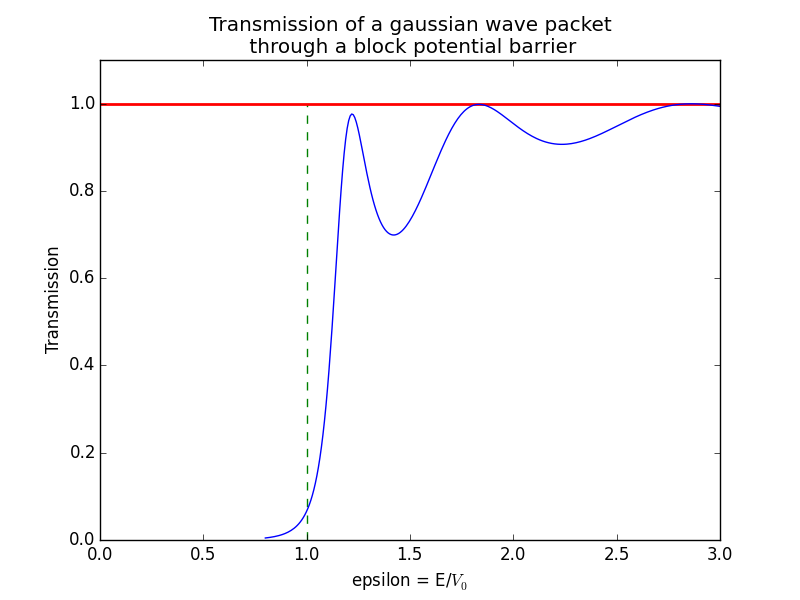

In [20]:
Image(filename='./media/blok_barrier.png')

Comparing this shape to literature, we see that it is very much in agreement.

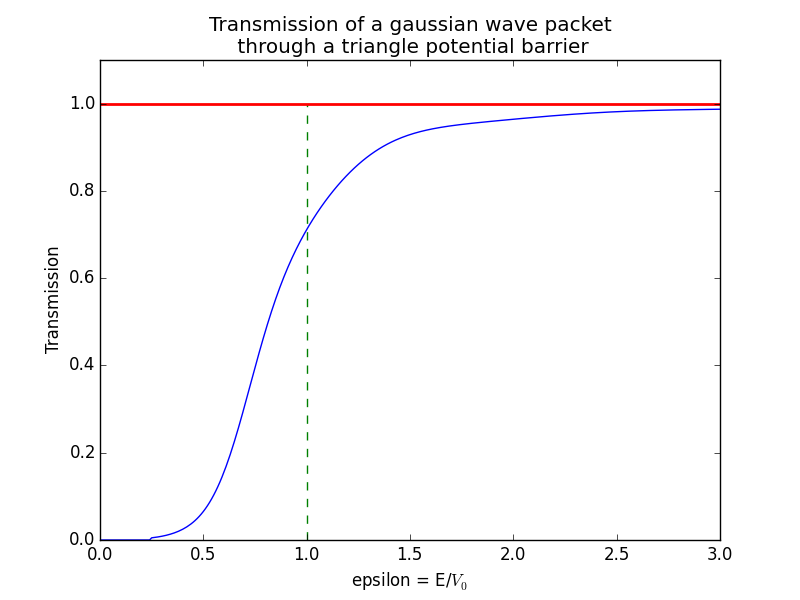

In [21]:
Image(filename='./media/triangle_barrier.png')

The shape of the graph we found for the triangle barrier is also in agreement with literature, as can be seen in <a href="http://rspa.royalsocietypublishing.org/content/early/2011/05/13/rspa.2011.0025.figures-only">this paper</a> 

## 2D Wavefront incident on a double slit

In [22]:
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

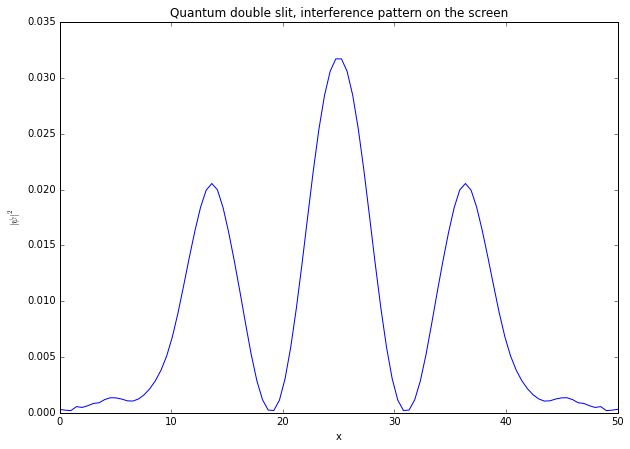

In [23]:
# Crank-Nicolson method QD time evolution simulation of a gaussian
# wavefront incident on a double slit
def main():

    ## simulation constants ##

    dt = .05            # time step
    dx = .5             # spatial grid distance
    L = 50.             # simulation space length
    k = 15.             # absolute value wave vector
    x0 = 0.25*L         # starting point wave front
    x1 = 0.25*L         # screen distance
    a = 0.6             # slit width
    d = 5               # slit spacing
    n = np.floor(L/dx)  # number of gridpoints along 1 dimension

    # initialize psi and the potential and calculate A and B for CN
    x, y = np.tile(np.linspace(0,L,n), n), np.repeat(np.linspace(0,L,n), n)
    psi = init_psi(x, x0, k, dx)
    v = double_slit_potential(x, y, L, a, d)
    A, B = calculate_AB(dx, dt, v, n)

    # find the interference pattern at the screen
    interference = run(psi, A, B, L, n, x1)

    # plot the
    plot_interference(np.linspace(0,L,n), interference)

###############
## functions ##
###############

# calculate the matrices for the Crank-Nicolson method
# A = Identity + constant*Hamiltonian
# B = Identity - constant*Hamiltonian
def calculate_AB(dx, dt, v, n):
    N = n**2

    # two constants to simplify the expressions
    c1 = 1.j * dt / (4. * dx**2)
    c2 = 1.j * dt / 2.

    temp = np.ones((1,n))
    temp[0,n-1] = 0.0
    temp = np.tile(temp, n)

    A = sparse.diags(1.+4.*c1+c2*v, 0) \
        - c1*sparse.eye(N,N,n) - c1*sparse.eye(N,N,-n) \
        - c1*sparse.diags(temp[0,0:(N-1)],-1) - c1*sparse.diags(temp[0,0:(N-1)],1)
    B = sparse.diags(1.-4.*c1-c2*v, 0) \
        + c1*sparse.eye(N,N,n) + c1*sparse.eye(N,N,-n) \
        + c1*sparse.diags(temp[0,0:(N-1)],-1) + c1*sparse.diags(temp[0,0:(N-1)],1)


    return A, B

# run the time evolution and return the transmission by solving the
# matrix equation A*psi(t+dt) = B*psi(t) using the bicgstab method.
def run(psi, A, B, L, n, x1):

    psiPlot = np.abs(psi.reshape(n,n)**2)
    interference = psiPlot[:,np.round(3.*n/4.)]
    for i in range(300):
        [psi, error] = linalg.bicgstab(A, B*psi,x0=psi)
        if error != 0: sys.exit("bicgstab did not converge")

        psiPlot = np.abs(psi.reshape(n,n)**2)
        interference += psiPlot[:,np.round((x1+0.5*L)*n/L)]

    return interference

# initialize the wave function
def init_psi(x, x0, k, dx):

    psi = np.exp(-0.1*((x-x0)**2)) * np.exp(1.j*k*x)  # gaussian front
    psi /= np.sqrt(sum(abs(psi)**2*dx**2))  # normalize the wave function

    return psi

# initialize a double slit potential barrier at
def double_slit_potential(x, y, L, a, d):

    v = 12.5*(np.abs(3*L/8 - x) < a)
    v2 = 1.0*(np.abs((L-d)/2 - y) > a)
    v3 = 1.0*(np.abs((L+d)/2 - y) > a)

    return v2 * v * v3

# plots the interference after the run
def plot_interference(x, interference):

    fig=plt.figure(figsize=(10, 7))
    plt.plot(x, interference, 'b')
    plt.title("Quantum double slit, interference pattern on the screen")
    plt.xlabel("x")
    plt.ylabel("$|\psi|^2$")
    plt.show()


##############
##   main   ##
##############
main()


### Animation of the wavefront hitting the double slit 

In [24]:
from IPython.display import HTML
HTML("""
<video width="600" height="480" controls>
  <source src="./media/animation.mp4" type="video/mp4">
  <source src="./media/animation.webm" type="video/webm">
</video>
""")